In [ ]:
import yaml
import pathlib
from eval_callbacks import plot_top_k_by_slice, compute_metrics_table, \
        plot_metric_norm, predictions_cache, plot_calibration
from models.main_uncertainty import load_model_config
import torch
import gc
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import pandas
pandas.options.display.float_format = '{:,.2f}'.format
%precision %.2f

In [2]:
# CONSTANTS
# DATA_DIRECTORY = 'single_coil' # Change to path to data directory
# DATA_DIRECTORY = '../fastMRIData'
DATA_DIRECTORY = '../../fastMRI/fastMRIData'

In [3]:
class FakeArgs():
    """ Mock non-essential arguments that do not vary across validation.
    """
    
    def __init__(self, value_dict):
        # Default arguments that stay consistent for all evaluation.
        self.num_workers = 0
        self.batch_size = 1
        self.resolution = 320
        self.overfit = False
        self.challenge = 'singlecoil'
        self.data_path = pathlib.Path(DATA_DIRECTORY) # Replace with correct data directory
        for k, v in value_dict.items():
            setattr(self, k, v)

## Uncertainty Experiments

In [4]:
# Overwrite functions from main.
from models.main_uncertainty import evaluate, create_data_loaders, load_model, load_model_config
def evaluate_callbacks_on_uncertainty_model(model_name, checkpoint_file, callbacks, sample_rate=1, 
                                            batches_per_volume=1, accelerations=[4, 8], 
                                            center_fractions=[0.08, 0.04], model_config=None):
    """ Wrapper around the evaluation function in main_uncertainty.py
    Args:
        model_name (str):  Model class string
        checkpoint_file (str): Path to trained model checkpoint
        callbacks (list): List of callback functions to call to generate figures/tables
    """
    module = __import__('models', fromlist=[model_name])  
    mri_model = getattr(module, model_name)(model_config)
    _, model, _ = load_model(checkpoint_file, mri_model)
    args = FakeArgs(dict(
        accelerations=accelerations,
        center_fractions=center_fractions,
        model=model_name,
        batches_per_volume=batches_per_volume,
        sample_rate=sample_rate
    ))
    _, data_loader, _ = create_data_loaders(args, mri_model)
    evaluate('cuda', model_name, model, mri_model.inference, data_loader, eval_callbacks=callbacks, batches_per_volume=batches_per_volume)
    del model

In [5]:
# TOP-K Plots
top_k_plotter = plot_top_k_by_slice.PlotTopKBySlice()
evaluate_callbacks_on_uncertainty_model(
    'LossPredictionModel', 
    'experiments/confidence/loss_prediction_2019-04-07T22:27:22.967707/model.pt', 
    [lambda x: top_k_plotter(x, 'Loss Prediction Network (L1)')],                       
    model_config=load_model_config('models/uncertainty/loss_prediction/configs/unet.yaml')
)
m1_data = top_k_plotter.produce_plot_data()

/home/ssegal/miniconda2/envs/fastmri/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [6]:
top_k_plotter = plot_top_k_by_slice.PlotTopKBySlice()
evaluate_callbacks_on_uncertainty_model(
    'LossPredictionModel', 
    'experiments/new/loss_prediction_ssim_2019-04-09T22:59:56.709682/model.pt', 
    [lambda x: top_k_plotter(x, 'Loss Prediction Network (SSIM)')],                       
    model_config=load_model_config('models/uncertainty/loss_prediction/configs/unet_ssim.yaml'),
)
m2_data = top_k_plotter.produce_plot_data(compute_baseline=False)

In [7]:
top_k_plotter = plot_top_k_by_slice.PlotTopKBySlice()
evaluate_callbacks_on_uncertainty_model(
    'RankingBaseline', 
    'experiments/entropy/entropy0.1_2019-04-07T14:13:38.948082/model.pt', 
    [lambda x: top_k_plotter(x, 'Ranking Network')],                       
    model_config=None,
)
m3_data = top_k_plotter.produce_plot_data(compute_baseline=False)

In [8]:
top_k_plotter = plot_top_k_by_slice.PlotTopKBySlice()
evaluate_callbacks_on_uncertainty_model(
    'DensityNetwork', 
    'experiments/gaussian/model.pt', 
    [lambda x: top_k_plotter(x, 'Density Network')],                       
    model_config=None,
    sample_rate=0.1
)
m4_data = top_k_plotter.produce_plot_data(compute_baseline=False)

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

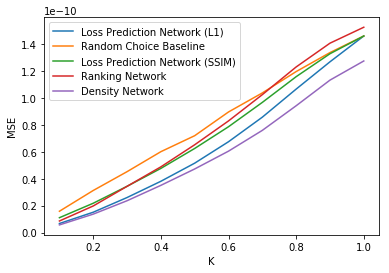

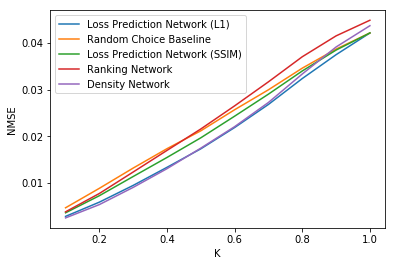

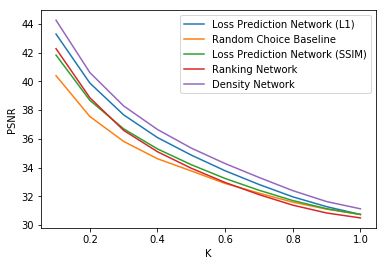

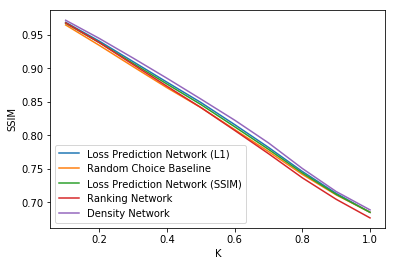

In [10]:
import importlib
importlib.reload(plot_top_k_by_slice)
top_k_plotter = plot_top_k_by_slice.PlotTopKBySlice()
top_k_plotter.produce_plot([m1_data, m2_data, m3_data, m4_data])

In [ ]:
from eval_callbacks import qualitative_loss_prediction
# Qualitative Uncertainty Plots
qualitative = qualitative_loss_prediction.QualitativeLossPrediction()
evaluate_callbacks_on_uncertainty_model(
    'LossPredictionModel', 
    'experiments/confidence/loss_prediction_2019-04-07T22:27:22.967707/model.pt', 
    [lambda x: qualitative(x, 'Loss Prediction Network (L1)')],                       
    model_config=load_model_config('models/uncertainty/loss_prediction/configs/unet.yaml'),
)

In [ ]:
import importlib
importlib.reload(display_slices)
cb = display_slices.DisplaySlices(qualitative.get_least_confident(8))
cache.run_callback(cb)
fig = cb.plot_figure()

In [ ]:
import importlib
importlib.reload(display_slices)
cb = display_slices.DisplaySlices(qualitative.get_most_confident(8))
cache.run_callback(cb)
fig = cb.plot_figure()

/home/sergio.casas/anaconda3/envs/fastmri/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


WITHIN01 Density Network 0.41959803298136117 0.0920676807241792 0.08
WITHIN03 Density Network 0.8260994009704172 0.26754510088919287 0.24
WITHIN05 Density Network 0.9442409130258208 0.41959803298136117 0.39
WITHIN1 Density Network 0.9954912202889877 0.6831585317629959 0.69
WITHIN20 Density Network 0.9998291616792065 0.9025527824683652 0.95
WITHIN30 Density Network 0.9999690064979481 0.9676099467766758 0.99


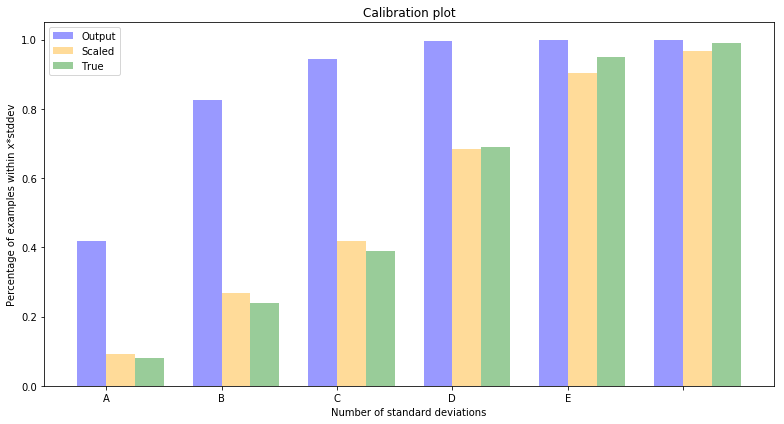

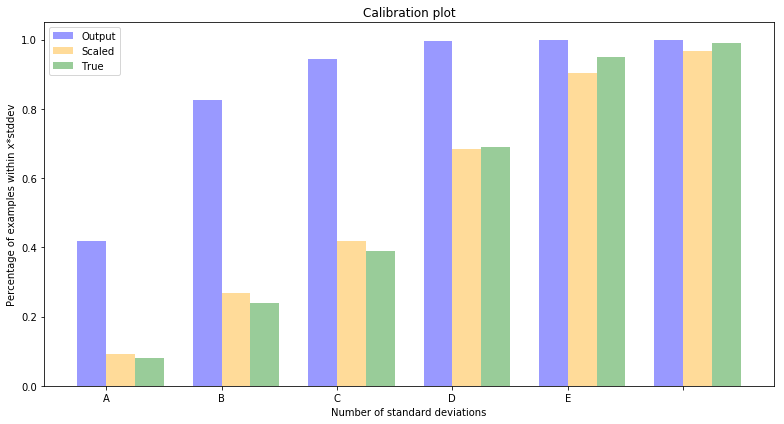

In [5]:
plotter_calibration = plot_calibration.PlotCalibration()
evaluate_callbacks_on_uncertainty_model(
    'DensityNetwork', 
    '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_gaussian_2019-03-31T23:50:40.960878/best_model.pt', 
    [lambda x: plotter_calibration(x, 'Density Network')],                       
    model_config=None,
    sample_rate=0.1
)
plotter_calibration.print_calibration()
plotter_calibration.produce_plot()

#### Uncertainty (Pixel)

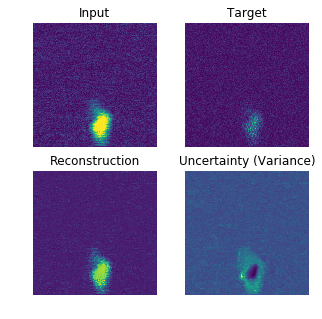

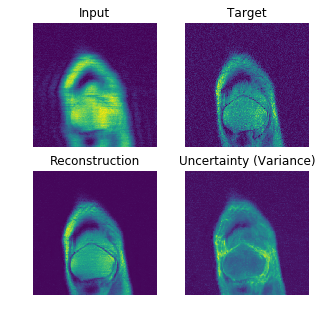

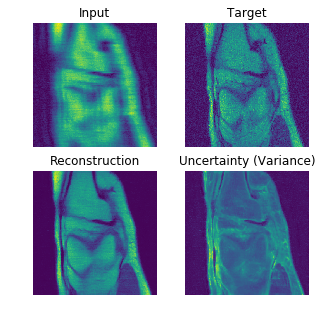

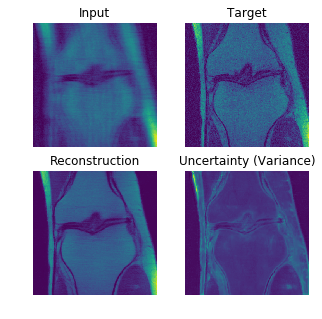

In [8]:
from eval_callbacks import visualize_pixel_uncertainty
import importlib
importlib.reload(visualize_pixel_uncertainty)
visualizer = visualize_pixel_uncertainty.VisualizePixelUncertainty(25)
evaluate_callbacks_on_uncertainty_model(
    'DensityNetwork', 
    'experiments/gaussian/model.pt', 
    [lambda x: visualizer(x, 'Density Network')],                       
    model_config=None,
    sample_rate=0.05
)
x = visualizer.show_images()

# Volumes  Experiments

In [4]:
# Overwrite functions from main.
from models.main import evaluate, create_data_loaders, load_model
from eval_callbacks import compute_metrics_table
import importlib
def evaluate_callbacks_on_general_model(model_name, checkpoint_file, callbacks,
                                        accelerations, center_fractions, 
                                        sample_rate=1, limit_examples=None, batches_per_volume=1, 
                                        num_slices=3):
    """ Wrapper around the evaluation function in main.py
    Args:
        model_name (str):  model name (directory name)
        checkpoint_file (str): Path to trained model checkpoint
        callbacks (list): List of callback functions to call to generate figures/tables
    """
    mri_model = importlib.import_module('.'.join(['models', model_name, 'train']))
    _, model, _ = load_model(checkpoint_file, mri_model, num_slices)
    args = FakeArgs(dict(
        accelerations=accelerations,
        center_fractions=center_fractions,
        model=model_name,
        batches_per_volume=batches_per_volume,
        sample_rate=sample_rate,
        checkpoint=checkpoint_file,
        num_volumes=num_slices,
        eval=True
    ))
    train_loader, dev_loader, display_loader, test_loader  = create_data_loaders(args)
    evaluate('cuda', model_name, model, mri_model.inference, dev_loader, limit_examples=limit_examples, eval_callbacks=callbacks, batches_per_volume=batches_per_volume)
    del model

# Qualitative results

In [5]:
experiments = {
    'UNet':{
        'module_name': 'unet', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_2019-03-29T10:40:05.622507/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'UNet Multi Slice High Capacity (3 Slices)':{
        'module_name': 'unet_volumes', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_volumes_3_high_capacity/best_model.pt',
        'num_slices': 3,
        'batches_per_volume': 4
    }
}

UNet
UNet Multi Slice High Capacity (3 Slices)
UNet
UNet Multi Slice High Capacity (3 Slices)


[<Figure size 720x432 with 6 Axes>, <Figure size 720x432 with 6 Axes>]

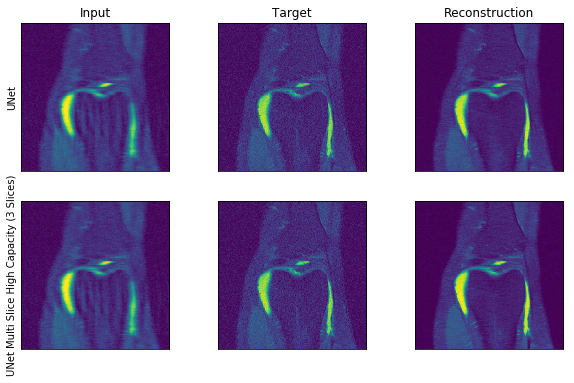

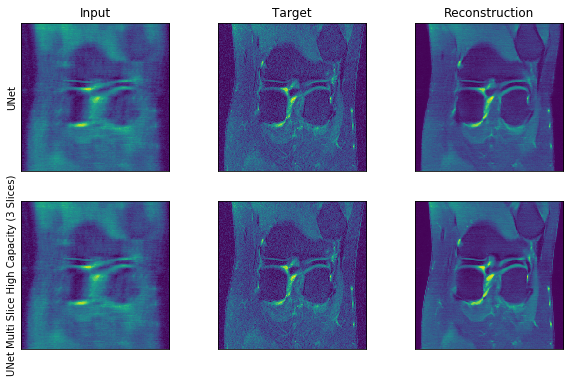

In [16]:
from eval_callbacks import visualize_normal_model
import importlib
importlib.reload(visualize_normal_model)

figs = []
settings = [(13, [4], [0.08]),(25, [8], [0.04])]
for f, a, c in settings:
    visualizer = visualize_normal_model.VisualizeNormalModel(f)
    for exp_name, exp in experiments.items():
        print(exp_name)
        evaluate_callbacks_on_general_model(
            exp['module_name'], 
            exp['checkpoint'], 
            accelerations=a, center_fractions=c,
            callbacks=[lambda x: visualizer(x, exp_name)],
            limit_examples=2,
            num_slices=exp['num_slices'],
            batches_per_volume=4
        )
        visualizer.reset_counter()
    figs.append(visualizer.show_images())
figs

# Tables

In [5]:
experiments = {
    'UNet Baseline (1 Slice)':{
        'module_name': 'unet', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_2019-03-29T10:40:05.622507/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'UNet Multi Slice (3 Slices)':{
        'module_name': 'unet_volumes', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_volumes_3/best_model.pt',
        'num_slices': 3,
        'batches_per_volume': 4
    },
    'UNet Multi Slice (5 Slices)':{
        'module_name': 'unet_volumes', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_volumes_5/best_model.pt',
        'num_slices': 5,
        'batches_per_volume': 4
    },
    'UNet Multi Slice High Capacity (3 Slices)':{
        'module_name': 'unet_volumes', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_volumes_3_high_capacity/best_model.pt',
        'num_slices': 3,
        'batches_per_volume': 4
    },
    'UNet Volume2Volume':{
        'module_name': 'unet_v2v', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_v2v_2019-04-10T11:46:11.856259/best_model.pt',
        'num_slices': None,
        'batches_per_volume': 1
    },
}

In [6]:
compute_metrics_table_4x = compute_metrics_table.ComputeMetricsTable()
compute_metrics_table_8x = compute_metrics_table.ComputeMetricsTable()
for experiment_name, exp in experiments.items():
    for acc, cf in [([4], [0.08]), ([8], [0.04])]:
        compute_metrics_table_fn = compute_metrics_table_4x if acc == [4] else compute_metrics_table_8x
        evaluate_callbacks_on_general_model(
            exp['module_name'], 
            exp['checkpoint'], 
            [lambda x: compute_metrics_table_fn(x, experiment_name)],
            accelerations=acc, center_fractions=cf,
            sample_rate=1.0,
            num_slices=exp['num_slices'],
            batches_per_volume=exp['batches_per_volume']
        )
        torch.cuda.empty_cache()
        gc.collect()

/home/sergio.casas/anaconda3/envs/fastmri/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [7]:
df_4x = compute_metrics_table_4x.produce_table()
df_8x = compute_metrics_table_8x.produce_table()

In [10]:
df_4x

,Experiment Name,MSE,NMSE,PSNR,SSIM
0,UNet Baseline (1 Slice),9.762E-11±8.022E-11,3.467E-2±2.493E-2,3.182E+1±3.245E+0,7.215E-1±1.300E-1
1,UNet Multi Slice (3 Slices),9.501E-11±7.710E-11,3.436E-2±2.507E-2,3.190E+1±3.303E+0,7.217E-1±1.310E-1
2,UNet Multi Slice (5 Slices),9.449E-11±7.631E-11,3.429E-2±2.508E-2,3.191E+1±3.314E+0,7.224E-1±1.310E-1
3,UNet Multi Slice High Capacity (3 Slices),9.007E-11±7.028E-11,3.373E-2±2.520E-2,3.206E+1±3.412E+0,7.266E-1±1.315E-1
4,UNet Volume2Volume,1.287E-10±1.108E-10,4.380E-2±3.148E-2,3.074E+1±3.110E+0,6.942E-1±1.353E-1


In [11]:
df_8x

,Experiment Name,MSE,NMSE,PSNR,SSIM
0,UNet Baseline (1 Slice),1.707E-10±1.727E-10,4.858E-2±2.820E-2,2.993E+1±2.627E+0,6.555E-1±1.467E-1
1,UNet Multi Slice (3 Slices),1.631E-10±1.618E-10,4.781E-2±2.862E-2,3.005E+1±2.699E+0,6.569E-1±1.475E-1
2,UNet Multi Slice (5 Slices),1.618E-10±1.595E-10,4.770E-2±2.869E-2,3.007E+1±2.716E+0,6.577E-1±1.478E-1
3,UNet Multi Slice High Capacity (3 Slices),1.497E-10±1.428E-10,4.627E-2±2.912E-2,3.029E+1±2.844E+0,6.634E-1±1.493E-1
4,UNet Volume2Volume,2.503E-10±2.586E-10,6.652E-2±3.749E-2,2.848E+1±2.486E+0,6.212E-1±1.451E-1


## Consistency experiments

In [5]:
experiments = {
    'UNet Baseline':{
        'module_name': 'unet', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_2019-03-29T10:40:05.622507/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'UNet Complex':{
        'module_name': 'unet_complex', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_complex_crop_2019-04-10T23:50:29.415316/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'Unet Consistent':{
        'module_name': 'unet_image_fcn_consistent', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_image_fcn_consistent_renorm_2019-03-31T00:35:38.212462/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'UNet Consistent Huber Loss':{
        'module_name': 'unet_image_fcn_consistent', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_image_fcn_consistent_renorm_smooth_2019-03-31T01:44:07.513074/best_model.pt',
        'num_slices':1,
        'batches_per_volume': 4
    },
    'UNet Consistent Adversarial':{
        'module_name': 'gan_image_fcn_consistent', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/gan_image_fcn_consistent_renorm_2019-03-31T23:06:39.316422/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
    'UNet Consistent SSIM':{
        'module_name': 'unet_image_fcn_consistent', 
        'checkpoint': '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_image_fcn_consistent_renorm_ssim_2019-03-29T10:30:45.978999/best_model.pt',
        'num_slices': 1,
        'batches_per_volume': 4
    },
}

In [6]:
compute_metrics_table_4x_consistency = compute_metrics_table.ComputeMetricsTable()
compute_metrics_table_8x_consistency = compute_metrics_table.ComputeMetricsTable()
for experiment_name, exp in experiments.items():
    for acc, cf in [([4], [0.08]), ([8], [0.04])]:
        print(experiment_name, acc[0])
        compute_metrics_table_fn = compute_metrics_table_4x_consistency if acc == [4] else compute_metrics_table_8x_consistency
        evaluate_callbacks_on_general_model(
            exp['module_name'], 
            exp['checkpoint'], 
            [lambda x: compute_metrics_table_fn(x, experiment_name)],
            accelerations=acc, center_fractions=cf,
            sample_rate=1.0,
            num_slices=exp['num_slices'],
            batches_per_volume=exp['batches_per_volume']
        )
        torch.cuda.empty_cache()
        gc.collect()


UNet Baseline 4


/home/sergio.casas/anaconda3/envs/fastmri/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


UNet Baseline 8
UNet Complex 4
UNet Complex 8
Unet Consistent 4
Unet Consistent 8
UNet Consistent Huber Loss 4
UNet Consistent Huber Loss 8
UNet Consistent Adversarial 4
UNet Consistent Adversarial 8
UNet Consistent SSIM 4
UNet Consistent SSIM 8


In [10]:
df_4x_consistency = compute_metrics_table_4x_consistency.produce_table()
df_8x_consistency = compute_metrics_table_8x_consistency.produce_table()

In [11]:
df_4x_consistency

,Experiment Name,MSE,NMSE,PSNR,SSIM
0,UNet Baseline,9.762E-11±8.022E-11,3.467E-2±2.493E-2,3.182E+1±3.245E+0,7.215E-1±1.300E-1
1,UNet Complex,1.003E-10±8.471E-11,3.507E-2±2.507E-2,3.174E+1±3.200E+0,7.180E-1±1.303E-1
2,Unet Consistent,9.531E-11±7.327E-11,3.599E-2±2.743E-2,3.180E+1±3.454E+0,7.094E-1±1.386E-1
3,UNet Consistent Huber Loss,9.703E-11±7.539E-11,3.614E-2±2.735E-2,3.175E+1±3.406E+0,7.081E-1±1.377E-1
4,UNet Consistent Adversarial,9.056E-11±6.766E-11,3.521E-2±2.738E-2,3.197E+1±3.552E+0,7.170E-1±1.360E-1
5,UNet Consistent SSIM,9.506E-11±7.284E-11,3.594E-2±2.747E-2,3.181E+1±3.454E+0,7.143E-1±1.361E-1


In [12]:
df_8x_consistency

,Experiment Name,MSE,NMSE,PSNR,SSIM
0,UNet Baseline,1.707E-10±1.727E-10,4.858E-2±2.820E-2,2.993E+1±2.627E+0,6.555E-1±1.467E-1
1,UNet Complex,1.817E-10±1.898E-10,5.007E-2±2.828E-2,2.975E+1±2.555E+0,6.522E-1±1.450E-1
2,Unet Consistent,1.716E-10±1.671E-10,5.044E-2±3.067E-2,2.983E+1±2.734E+0,6.422E-1±1.522E-1
3,UNet Consistent Huber Loss,1.742E-10±1.706E-10,5.071E-2±3.057E-2,2.979E+1±2.712E+0,6.403E-1±1.505E-1
4,UNet Consistent Adversarial,1.580E-10±1.501E-10,4.840E-2±3.072E-2,3.009E+1±2.846E+0,6.514E-1±1.513E-1
5,UNet Consistent SSIM,1.714E-10±1.652E-10,5.038E-2±3.063E-2,2.983E+1±2.735E+0,6.467E-1±1.501E-1


In [ ]:
metric_norm_plotter = plot_metric_norm.PlotMetricNorm()
evaluate_callbacks_on_general_model(
    'unet_image_fcn_consistent', 
    '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_image_fcn_consistent_renorm_ssim_2019-03-29T10:30:45.978999/best_model.pt', 
    [lambda x: metric_norm_plotter(x, 'U-net consitent SSIM')],
    num_slices=1,
    sample_rate=1.0,
    batches_per_volume=2
)
evaluate_callbacks_on_general_model(
    'unet', 
    '/home/sergio.casas/fastMRI/fastMRIPrivate/vector_2903/unet_2019-03-29T10:40:05.622507/best_model.pt', 
    [lambda x: metric_norm_plotter(x, 'U-net')],
    num_slices=1,
    sample_rate=1.0,
    batches_per_volume=2,
    batch_size=16
)


In [ ]:
figs = metric_norm_plotter.produce_plot()